In [1]:
import tensorflow as tf
import os
import numpy as np
import random
SEED = 0
#------------------------------------------------------------------------------------
def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
#------------------------------------------------------------------------------------
def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

# Call the above function with seed value
set_global_determinism(seed=SEED)
#-----------------------------------------------------------------------------------

In [2]:
%matplotlib notebook
import pandas as pd
from data_extraction import *
from resp_signal_extraction import *
from rr_extration import *
from sklearn.preprocessing import MinMaxScaler
import re
import pickle as pkl
from teacher_model import *
from student_model import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
import matplotlib.pyplot as plt
from filters import *
import tqdm
import plotly as py
import plotly.figure_factory as ff
import ipywidgets as widgets
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
py.offline.init_notebook_mode(connected = True)
from plotly import tools
import plotly.express as px

In [3]:
input_conf = 'confd'

In [4]:
with open('output','rb') as f:
    output_data = pkl.load(f)

with open('input','rb') as f:
    input_data = pkl.load(f)

with open('raw_signal.pkl','rb') as f:
    raw_data = pkl.load(f)

input_data = np.transpose(input_data, (0,2,1))
raw_data = np.transpose(raw_data, (0,2,1))
annotation = pd.read_pickle('/media/acrophase/pose1/charan/BR_Uncertainty/MONTE_CARLO/annotation.pkl')
reference_rr = (annotation['Reference_RR'].values).reshape(-1,1)

input_data = np.around(input_data , decimals = 4)
raw_data = np.around(raw_data , decimals = 4)
output_data = np.around(output_data , decimals = 4)
reference_rr = np.around(reference_rr , decimals = 4)

tensor_input = tf.convert_to_tensor(input_data, dtype = 'float32')
tensor_output = tf.convert_to_tensor(output_data, dtype = 'float32')
tensor_ref_rr = tf.convert_to_tensor(reference_rr, dtype = 'float32')
tensor_raw_data = tf.convert_to_tensor(raw_data, dtype = 'float32')
training_ids = annotation['patient_id'] < 13

x_train_data = tensor_input[tf.convert_to_tensor(training_ids.values)]
x_test_data = tensor_input[tf.convert_to_tensor(~(training_ids.values))]
x_train_ref_rr = tensor_ref_rr[tf.convert_to_tensor(training_ids.values)]
x_test_ref_rr = tensor_ref_rr[tf.convert_to_tensor(~(training_ids.values))]
x_train_raw_sig = tensor_raw_data[tf.convert_to_tensor(training_ids.values)]
x_test_raw_sig = tensor_raw_data[tf.convert_to_tensor(~(training_ids.values))]

y_train_data = tensor_output[tf.convert_to_tensor(training_ids.values)]
y_test_data = tensor_output[tf.convert_to_tensor(~(training_ids.values))]

2022-02-15 14:52:06.691995: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 14:52:06.697229: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 14:52:06.697551: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 14:52:06.718314: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [5]:
if input_conf == 'confd':
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train_data , y_train_data, x_train_ref_rr))
        train_dataset = train_dataset.shuffle(len(x_train_data)).batch(128)
        test_dataset = tf.data.Dataset.from_tensor_slices((x_test_data , y_test_data, x_test_ref_rr))
        test_dataset = test_dataset.batch(128)

In [6]:
def extremas_extraction(signal):
    avg_breath_duration = np.array([])
    extrema_relevent = []
    for item in signal:
        amplitude = np.array([])
        pos_peaks , _ = scipy.signal.find_peaks(item , height = [-3000,3000])
        neg_peaks , _ = scipy.signal.find_peaks(-1*item , height = [-3000 , 3000])
        extremas = np.concatenate((pos_peaks , neg_peaks))
        extremas = np.sort(extremas)
        for i in range(len(extremas)):
            amplitude = np.append(amplitude , item[int(extremas[i])])
        amplitude_diff = np.abs(np.diff(amplitude))
        q3 = np.percentile(amplitude_diff , 75)
        threshold = 0.3*q3
        eliminate_pairs_of_extrema = 1
        while(eliminate_pairs_of_extrema):
            amps = np.array([])
            if len(extremas)<3:
                eliminate_pairs_of_extrema = 0
                continue
            for i in range(len(extremas)):
                amps = np.append(amps , item[int(extremas[i])])
            amp_diff = np.abs(np.diff(amps)) 
            min_amp_diff , index = min(amp_diff) , np.argmin(amp_diff)
            #print(min_amp_diff)
            if min_amp_diff > threshold:
                eliminate_pairs_of_extrema = 0
                #extrema_relevent = extremas
            else:
                extremas = np.concatenate((extremas[0:index] , extremas[index+2 :]))
                #amplitude_diff = np.delete(amplitude_diff , index)
        if item[int(extremas[0])] < item[int(extremas[1])]:
            extremas = extremas[1:]
        if item[int(extremas[-1])] < item[int(extremas[-2])]:
            extremas = extremas[:-1]
        no_of_breaths = (len(extremas)-1)/2
        breath_duration = extremas[-1] - extremas[0]
        avg_breath_duration = np.append(avg_breath_duration , breath_duration/no_of_breaths)
        extrema_relevent.append(extremas)
    return avg_breath_duration , extrema_relevent

In [7]:
ref_sig = y_test_data.numpy()
fbpB , fbpA = band_pass(0.1,0.7,8)
final_ref_resp_sig = []
for item in ref_sig:
    final_ref_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
final_ref_resp_sig = np.array(final_ref_resp_sig)

In [8]:
if input_conf == 'confd':
    final_output = np.array([])
    final_output_rr = np.array([])
    final_attn1 = np.array([])
    final_attn2 = np.array([])
    final_attn3 = np.array([])
    final_attn4 = np.array([])
    final_attn5 = np.array([])
    final_attn6 = np.array([])
    final_attn7 = np.array([])
    final_attn8 = np.array([])
    final_attn9 = np.array([])
    bottleneck_final = np.array([])
    model_input_shape = (128,3)
    model  = BRUnet_Multi_resp_ATT_MC(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,128,3)))
    model.load_weights('/media/acrophase/pose1/charan/BR_Uncertainty/Knowledge_Distill/SAVED_TEACHER_MODEL/TEACHER_MODEL/best_model_10.01_0.0001_100.h5')
    for i in tqdm.tqdm(range(10)):
        test_loss_list = []
        output_data = tf.convert_to_tensor([])
        output_data_rr = tf.convert_to_tensor([])
        attn1 = tf.convert_to_tensor([])
        attn2 = tf.convert_to_tensor([])
        attn3 = tf.convert_to_tensor([])
        attn4 = tf.convert_to_tensor([])
        attn5 = tf.convert_to_tensor([])
        attn6 = tf.convert_to_tensor([])
        attn7 = tf.convert_to_tensor([])
        attn8 = tf.convert_to_tensor([])
        attn9 = tf.convert_to_tensor([])
        e6 = tf.convert_to_tensor([])
        for step , (x_batch_test,y_batch_test,x_batch_test_ref_rr) in enumerate(test_dataset):
            test_output,test_out_rr,e_6,at_1,at_2,at_3,at_4,at_5,at_6,at_7,at_8,at_9 = model(x_batch_test)
            test_loss_resp = loss_fn(y_batch_test  , test_output)
            test_loss_rr = loss_fn(x_batch_test_ref_rr , test_out_rr)
            test_loss = test_loss_resp + test_loss_rr
            if step == 0:
                output_data = test_output
                output_data_rr = test_out_rr
                attn1 = at_1
                attn2 = at_2
                attn3 = at_3
                attn4 = at_4
                attn5 = at_5
                attn6 = at_6
                attn7 = at_7
                attn8 = at_8
                attn9 = at_9
                e6 = e_6
            else:
                output_data = tf.concat([output_data , test_output] , axis = 0)
                output_data_rr = tf.concat([output_data_rr , test_out_rr] , axis = 0)
                attn1 = tf.concat([attn1 , at_1] , axis = 0)
                attn2 = tf.concat([attn2 , at_2] , axis = 0)
                attn3 = tf.concat([attn3 , at_3] , axis = 0)
                attn4 = tf.concat([attn4 , at_4] , axis = 0)
                attn5 = tf.concat([attn5 , at_5] , axis = 0)
                attn6 = tf.concat([attn6 , at_6] , axis = 0)
                attn7 = tf.concat([attn7 , at_7] , axis = 0)
                attn8 = tf.concat([attn8 , at_8] , axis = 0)
                attn9 = tf.concat([attn9 , at_9] , axis = 0)
                e6 = tf.concat([e6 , e_6] , axis = 0)
            test_loss_list.append(test_loss)
        output_array = output_data.numpy()
        output_array_rr = output_data_rr.numpy()
        attn1_array = attn1.numpy()
        attn2_array = attn2.numpy()
        attn3_array = attn3.numpy()
        attn4_array = attn4.numpy()
        attn5_array = attn5.numpy()
        attn6_array = attn6.numpy()
        attn7_array = attn7.numpy()
        attn8_array = attn8.numpy()
        attn9_array = attn9.numpy()
        e6_array = e6.numpy()
        output_array = output_array.reshape(output_array.shape[-1],output_array.shape[0],output_array.shape[1])
        output_array_rr = output_array_rr.reshape(output_array_rr.shape[-1],output_array_rr.shape[0],output_array_rr.shape[1])
        attn1_array = np.expand_dims(attn1_array,axis = 0)
        attn2_array = np.expand_dims(attn2_array,axis = 0)
        attn3_array = np.expand_dims(attn3_array,axis = 0)
        attn4_array = np.expand_dims(attn4_array,axis = 0)
        attn5_array = np.expand_dims(attn5_array,axis = 0)
        attn6_array = np.expand_dims(attn6_array,axis = 0)
        attn7_array = np.expand_dims(attn7_array,axis = 0)
        attn8_array = np.expand_dims(attn8_array,axis = 0)
        attn9_array = np.expand_dims(attn9_array,axis = 0)
        e6_array = np.expand_dims(e6_array,axis = 0)
        if i == 0:
            final_output = output_array
            final_output_rr = output_array_rr
            final_attn1 = attn1_array
            final_attn2 = attn2_array
            final_attn3 = attn3_array
            final_attn4 = attn4_array
            final_attn5 = attn5_array
            final_attn6 = attn6_array
            final_attn7 = attn7_array
            final_attn8 = attn8_array
            final_attn9 = attn9_array
            bottleneck_final = e6_array
        else:
            final_output = np.vstack((final_output,output_array))
            final_output_rr = np.vstack((final_output_rr,output_array_rr))
            final_attn1 = np.vstack((final_attn1,attn1_array))
            final_attn2 = np.vstack((final_attn2,attn2_array))
            final_attn3 = np.vstack((final_attn3,attn3_array))
            final_attn4 = np.vstack((final_attn4,attn4_array))
            final_attn5 = np.vstack((final_attn5,attn5_array))
            final_attn6 = np.vstack((final_attn6,attn6_array))
            final_attn7 = np.vstack((final_attn7,attn7_array))
            final_attn8 = np.vstack((final_attn8,attn8_array))
            final_attn9 = np.vstack((final_attn9,attn9_array))
            bottleneck_final = np.vstack((bottleneck_final,e6_array))
    model.summary()

2022-02-15 14:52:08.123670: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8202
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.52s/it]

Model: "br_unet__multi_resp_att_mc"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 64, 32)            15136     
_________________________________________________________________
sequential_9 (Sequential)    (None, 32, 64)            64640     
_________________________________________________________________
sequential_14 (Sequential)   (None, 16, 128)           224000    
_________________________________________________________________
sequential_19 (Sequential)   (None, 8, 256)            957952    
_________________________________________________________________
sequential_24 (Sequential)   (None, 8, 512)            3562496   
_________________________________________________________________
sequential_29 (Sequential)   (None, 8, 1024)           11088896  
_________________________________________________________________
attention_block (AttentionBl multiple   

In [9]:
if input_conf == 'confd':
    #l = 0.1
    #drop_prob = 0.1
    #lam = 0.0001
    
    #l_rr = 0.01
    #drop_prob_rr = 0.1
    #lam_rr = 0.0001
    
    final_output_resp_sig = []
    inst_br_dur = []
    inst_ref_br_dur = []
    inst_rr = []
    inst_ref_rr = []
    
    final_attn1_output = np.mean(final_attn1 , axis = 0)
    final_attn2_output = np.mean(final_attn2 , axis = 0)
    final_attn3_output = np.mean(final_attn3 , axis = 0)
    final_attn4_output = np.mean(final_attn4 , axis = 0)
    final_attn5_output = np.mean(final_attn5 , axis = 0)
    final_attn6_output = np.mean(final_attn6 , axis = 0)
    final_attn7_output = np.mean(final_attn7 , axis = 0)
    final_attn8_output = np.mean(final_attn8 , axis = 0)
    final_attn9_output = np.mean(final_attn9 , axis = 0)
    bottleneck_output = np.mean(bottleneck_final , axis = 0)
    
    final_output_resp = np.mean(final_output,axis = 0)
    final_rr = np.mean(final_output_rr,axis = 0)
    #tau = (l**2) * (1-drop_prob) / (2. * lam)
    #tau_rr = (l_rr**2) * (1-drop_prob_rr) / (2. * lam_rr)
    
    final_var = np.var(final_output,axis = 0)
    final_var_rr = np.var(final_output_rr,axis = 0)
    #final_var += (tau**-1)
    #final_var_rr += (tau_rr**-1)
    output_copy = final_output_resp
    output_copy_rr = final_rr
    std_dev = np.sqrt(final_var)
    std_dev_rr_tech = np.sqrt(final_var_rr)
    for item in final_output_resp:
        final_output_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
        
    final_output_resp_sig = np.array(final_output_resp_sig)
    duration_resp,extremas_resp = extremas_extraction(final_output_resp_sig)
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    
    error_avg_breaths = np.abs(avg_ref_breath - final_rr)
    mae_avg_breath = np.mean(error_avg_breaths)
    rmse_avg_breath = np.sqrt(np.mean(error_avg_breaths**2))
    
    for item in extremas_resp:
        inst_br_dur.append(np.diff(item[0::2]))
    for item in extremas_ref_resp:
        inst_ref_br_dur.append(np.diff(item[0::2]))
    for item in inst_br_dur:
        inst_rr.append(np.mean(60*4/item))
    for item in inst_ref_br_dur:
        inst_ref_rr.append(np.mean(60*4/item))
    
    inst_rr = (np.array(inst_rr)).reshape(-1,1)
    inst_ref_rr = (np.array(inst_ref_rr)).reshape(-1,1)
    
    error_inst_breaths = np.abs(inst_ref_rr - inst_rr)
    mae_inst_breath = np.mean(error_inst_breaths)
    rmse_inst_breath = np.sqrt(np.mean(error_inst_breaths**2))
    
    samples = np.arange(0,len(final_rr)).reshape(-1,1)
    confd_data = np.hstack((samples,final_rr , std_dev_rr_tech,error_avg_breaths, error_inst_breaths))
    col_confd = ['Samples','Final RR Output (BrPM)' , 'Uncertainty', 'Error Avg Breath(BrPM)','Error Inst Breath(BrPM)']
    data_confd = pd.DataFrame(confd_data , columns = col_confd)
    
    print('Mean Absolute Error average wise for {} is: {}'.format(input_conf,mae_avg_breath))
    print('Root Mean Square Error average wise for {} is: {}'.format(input_conf,rmse_avg_breath))
    
    print('Mean Absolute Error instantaneous wise for {} is: {}'.format(input_conf,mae_inst_breath))
    print('Root Mean Square Error instantaneous wise for {} is: {}'.format(input_conf,rmse_inst_breath))
    

Mean Absolute Error average wise for confd is: 2.3371805239639163
Root Mean Square Error average wise for confd is: 2.9139802955622818
Mean Absolute Error instantaneous wise for confd is: 3.166354565516778
Root Mean Square Error instantaneous wise for confd is: 4.045955202293421


In [10]:
if input_conf == 'confd':
    fig1 = px.scatter(data_confd,x = 'Samples', y="Error Avg Breath(BrPM)",title="Uncertainty Distribution for "+input_conf.upper()+ " for average RR error" ,
                     color="Uncertainty", color_continuous_scale=px.colors.sequential.Viridis)
    
    fig2 = px.scatter(data_confd,x = 'Samples', y="Error Inst Breath(BrPM)",title="Uncertainty Distribution for "+input_conf.upper()+ " for instantaneous RR error" ,
                     color="Uncertainty", color_continuous_scale=px.colors.sequential.Viridis)
    fig1.show()
    fig2.show()

<IPython.core.display.Javascript object>


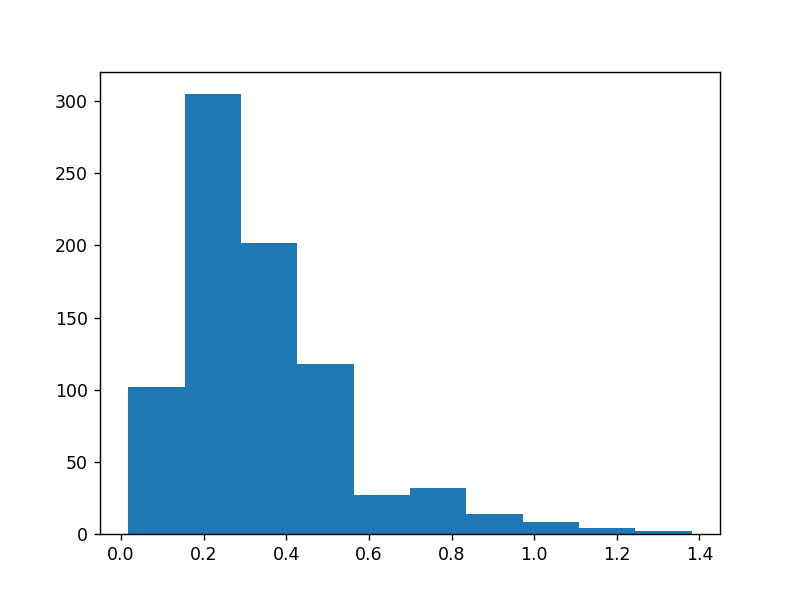

In [11]:
plt.figure(1)
plt.hist(std_dev_rr_tech)
plt.show()

In [12]:
thres_index_teach = np.where(std_dev_rr_tech>0.65)
for item in thres_index_teach[0]:
    error_inst_breaths[item] = 0
    error_avg_breaths[item] = 0
new_mae_avg_rr_teacher = np.mean(error_avg_breaths)
new_rmse_avg_rr_teacher = np.sqrt(np.mean(error_avg_breaths**2))

new_mae_inst_rr_teacher = np.mean(error_inst_breaths)
new_rmse_inst_rr_teacher = np.sqrt(np.mean(error_inst_breaths**2))

print('TEACHER--New Mean Absolute Error average wise for {} is: {}'.format(input_conf,new_mae_avg_rr_teacher))
print('TEACHER--New Root Mean Square Error average wise for {} is: {}'.format(input_conf,new_rmse_avg_rr_teacher))
    
print('TEACHER--New Mean Absolute Error instantaneous wise for {} is: {}'.format(input_conf,new_mae_inst_rr_teacher))
print('TEACHER--New Root Mean Square Error instantaneous wise for {} is: {}'.format(input_conf,new_rmse_inst_rr_teacher))

TEACHER--New Mean Absolute Error average wise for confd is: 2.1356000038095133
TEACHER--New Root Mean Square Error average wise for confd is: 2.791939133823287
TEACHER--New Mean Absolute Error instantaneous wise for confd is: 2.8878134677134404
TEACHER--New Root Mean Square Error instantaneous wise for confd is: 3.87389863892379


# STUDENT MODEL

In [13]:
if input_conf == 'confd':
    final_output = np.array([])
    final_output_rr = np.array([])
    final_attn1 = np.array([])
    final_attn2 = np.array([])
    #final_attn3 = np.array([])
    final_attn4 = np.array([])
    final_attn5 = np.array([])
    final_attn6 = np.array([])
    final_attn7 = np.array([])
    #final_attn8 = np.array([])
    #final_attn9 = np.array([])
    bottleneck_final = np.array([])
    model_input_shape = (128,3)
    model  = BRUnet_Multi_resp_student_2(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,128,3)))
    model.load_weights('/media/acrophase/pose1/charan/BR_Uncertainty/Knowledge_Distill/SAVED_STUDENT_MODEL_2/TEACHER_MODEL/best_model_10.01_0.0001_100.h5')
    for i in tqdm.tqdm(range(10)):
        test_loss_list = []
        output_data = tf.convert_to_tensor([])
        output_data_rr = tf.convert_to_tensor([])
        attn1 = tf.convert_to_tensor([])
        attn2 = tf.convert_to_tensor([])
        #attn3 = tf.convert_to_tensor([])
        attn4 = tf.convert_to_tensor([])
        attn5 = tf.convert_to_tensor([])
        attn6 = tf.convert_to_tensor([])
        attn7 = tf.convert_to_tensor([])
        #attn8 = tf.convert_to_tensor([])
        #attn9 = tf.convert_to_tensor([])
        e6 = tf.convert_to_tensor([])
        for step , (x_batch_test,y_batch_test,x_batch_test_ref_rr) in enumerate(test_dataset):
            test_output,test_out_rr,e_6,at_1,at_2,at_4,at_5,at_6,at_7 = model(x_batch_test)
            test_loss_resp = loss_fn(y_batch_test  , test_output)
            test_loss_rr = loss_fn(x_batch_test_ref_rr , test_out_rr)
            test_loss = test_loss_resp + test_loss_rr
            if step == 0:
                output_data = test_output
                output_data_rr = test_out_rr
                attn1 = at_1
                attn2 = at_2
                #attn3 = at_3
                attn4 = at_4
                attn5 = at_5
                attn6 = at_6
                attn7 = at_7
                #attn8 = at_8
                #attn9 = at_9
                e6 = e_6
            else:
                output_data = tf.concat([output_data , test_output] , axis = 0)
                output_data_rr = tf.concat([output_data_rr , test_out_rr] , axis = 0)
                attn1 = tf.concat([attn1 , at_1] , axis = 0)
                attn2 = tf.concat([attn2 , at_2] , axis = 0)
                #attn3 = tf.concat([attn3 , at_3] , axis = 0)
                attn4 = tf.concat([attn4 , at_4] , axis = 0)
                attn5 = tf.concat([attn5 , at_5] , axis = 0)
                attn6 = tf.concat([attn6 , at_6] , axis = 0)
                attn7 = tf.concat([attn7 , at_7] , axis = 0)
                #attn8 = tf.concat([attn8 , at_8] , axis = 0)
                #attn9 = tf.concat([attn9 , at_9] , axis = 0)
                e6 = tf.concat([e6 , e_6] , axis = 0)
            test_loss_list.append(test_loss)
        output_array = output_data.numpy()
        output_array_rr = output_data_rr.numpy()
        attn1_array = attn1.numpy()
        attn2_array = attn2.numpy()
        #attn3_array = attn3.numpy()
        attn4_array = attn4.numpy()
        attn5_array = attn5.numpy()
        attn6_array = attn6.numpy()
        attn7_array = attn7.numpy()
        #attn8_array = attn8.numpy()
        #attn9_array = attn9.numpy()
        e6_array = e6.numpy()
        output_array = output_array.reshape(output_array.shape[-1],output_array.shape[0],output_array.shape[1])
        output_array_rr = output_array_rr.reshape(output_array_rr.shape[-1],output_array_rr.shape[0],output_array_rr.shape[1])
        attn1_array = np.expand_dims(attn1_array,axis = 0)
        attn2_array = np.expand_dims(attn2_array,axis = 0)
        #attn3_array = np.expand_dims(attn3_array,axis = 0)
        attn4_array = np.expand_dims(attn4_array,axis = 0)
        attn5_array = np.expand_dims(attn5_array,axis = 0)
        attn6_array = np.expand_dims(attn6_array,axis = 0)
        attn7_array = np.expand_dims(attn7_array,axis = 0)
        #attn8_array = np.expand_dims(attn8_array,axis = 0)
        #attn9_array = np.expand_dims(attn9_array,axis = 0)
        e6_array = np.expand_dims(e6_array,axis = 0)
        if i == 0:
            final_output = output_array
            final_output_rr = output_array_rr
            final_attn1 = attn1_array
            final_attn2 = attn2_array
            #final_attn3 = attn3_array
            final_attn4 = attn4_array
            final_attn5 = attn5_array
            final_attn6 = attn6_array
            final_attn7 = attn7_array
            #final_attn8 = attn8_array
            #final_attn9 = attn9_array
            bottleneck_final = e6_array
        else:
            final_output = np.vstack((final_output,output_array))
            final_output_rr = np.vstack((final_output_rr,output_array_rr))
            final_attn1 = np.vstack((final_attn1,attn1_array))
            final_attn2 = np.vstack((final_attn2,attn2_array))
            #final_attn3 = np.vstack((final_attn3,attn3_array))
            final_attn4 = np.vstack((final_attn4,attn4_array))
            final_attn5 = np.vstack((final_attn5,attn5_array))
            final_attn6 = np.vstack((final_attn6,attn6_array))
            final_attn7 = np.vstack((final_attn7,attn7_array))
            #final_attn8 = np.vstack((final_attn8,attn8_array))
            #final_attn9 = np.vstack((final_attn9,attn9_array))
            bottleneck_final = np.vstack((bottleneck_final,e6_array))
    model.summary()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.02it/s]

Model: "br_unet__multi_resp_student_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_105 (Sequential)  (None, 32, 32)            15136     
_________________________________________________________________
sequential_110 (Sequential)  (None, 16, 64)            64640     
_________________________________________________________________
sequential_115 (Sequential)  (None, 8, 128)            224000    
_________________________________________________________________
sequential_120 (Sequential)  (None, 8, 1024)           9909248   
_________________________________________________________________
attention_block_9 (Attention multiple                  1054725   
_________________________________________________________________
sequential_127 (Sequential)  (None, 2, 32)             551360    
_________________________________________________________________
attention_block_10 (Attentio multiple

In [14]:
if input_conf == 'confd':
    #l = 0.1
    #drop_prob = 0.1
    #lam = 0.0001
    
    #l_rr = 0.01
    #drop_prob_rr = 0.1
    #lam_rr = 0.0001
    
    final_output_resp_sig = []
    inst_br_dur = []
    inst_ref_br_dur = []
    inst_rr = []
    inst_ref_rr = []
    
    final_attn1_output = np.mean(final_attn1 , axis = 0)
    final_attn2_output = np.mean(final_attn2 , axis = 0)
    #final_attn3_output = np.mean(final_attn3 , axis = 0)
    final_attn4_output = np.mean(final_attn4 , axis = 0)
    final_attn5_output = np.mean(final_attn5 , axis = 0)
    final_attn6_output = np.mean(final_attn6 , axis = 0)
    final_attn7_output = np.mean(final_attn7 , axis = 0)
    #final_attn8_output = np.mean(final_attn8 , axis = 0)
    #final_attn9_output = np.mean(final_attn9 , axis = 0)
    #bottleneck_output = np.mean(bottleneck_final , axis = 0)
    
    final_output_resp = np.mean(final_output,axis = 0)
    final_rr = np.mean(final_output_rr,axis = 0)
    #tau = (l**2) * (1-drop_prob) / (2. * lam)
    #tau_rr = (l_rr**2) * (1-drop_prob_rr) / (2. * lam_rr)
    
    final_var = np.var(final_output,axis = 0)
    final_var_rr = np.var(final_output_rr,axis = 0)
    #final_var += (tau**-1)
    #final_var_rr += (tau_rr**-1)
    output_copy = final_output_resp
    output_copy_rr = final_rr
    std_dev = np.sqrt(final_var)
    std_dev_rr_stu = np.sqrt(final_var_rr)
    for item in final_output_resp:
        final_output_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
        
    final_output_resp_sig = np.array(final_output_resp_sig)
    duration_resp,extremas_resp = extremas_extraction(final_output_resp_sig)
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    
    error_avg_breaths = np.abs(avg_ref_breath - final_rr)
    mae_avg_breath = np.mean(error_avg_breaths)
    rmse_avg_breath = np.sqrt(np.mean(error_avg_breaths**2))
    
    for item in extremas_resp:
        inst_br_dur.append(np.diff(item[0::2]))
    for item in extremas_ref_resp:
        inst_ref_br_dur.append(np.diff(item[0::2]))
    for item in inst_br_dur:
        inst_rr.append(np.mean(60*4/item))
    for item in inst_ref_br_dur:
        inst_ref_rr.append(np.mean(60*4/item))
    
    inst_rr = (np.array(inst_rr)).reshape(-1,1)
    inst_ref_rr = (np.array(inst_ref_rr)).reshape(-1,1)
    
    error_inst_breaths = np.abs(inst_ref_rr - inst_rr)
    mae_inst_breath = np.mean(error_inst_breaths)
    rmse_inst_breath = np.sqrt(np.mean(error_inst_breaths**2))
    
    samples = np.arange(0,len(final_rr)).reshape(-1,1)
    confd_data = np.hstack((samples,final_rr , std_dev_rr_stu,error_avg_breaths, error_inst_breaths))
    col_confd = ['Samples','Final RR Output (BrPM)' , 'Uncertainty', 'Error Avg Breath(BrPM)','Error Inst Breath(BrPM)']
    data_confd = pd.DataFrame(confd_data , columns = col_confd)
    
    print('Mean Absolute Error average wise for {} is: {}'.format(input_conf,mae_avg_breath))
    print('Root Mean Square Error average wise for {} is: {}'.format(input_conf,rmse_avg_breath))
    
    print('Mean Absolute Error instantaneous wise for {} is: {}'.format(input_conf,mae_inst_breath))
    print('Root Mean Square Error instantaneous wise for {} is: {}'.format(input_conf,rmse_inst_breath))
    

Mean Absolute Error average wise for confd is: 2.372381329528685
Root Mean Square Error average wise for confd is: 2.9556133698198166
Mean Absolute Error instantaneous wise for confd is: 3.342730850244106
Root Mean Square Error instantaneous wise for confd is: 4.1324037296331335


In [15]:
if input_conf == 'confc' or input_conf == 'confe' or input_conf == 'confd' or input_conf == 'conff':
    no_of_samples = 32*4
    x_unc = np.linspace(start = 0,stop = no_of_samples, num = no_of_samples)
    layout_epistemic = go.Layout(
    title = "Respiratory Waveform with Epistemic Uncertainty for "+ input_conf.upper(),
    yaxis = dict(
        title = 'Output Respiration Signal' 
    ),
    xaxis = dict(
        title = 'samples'
    )
    )
    def update_plot(signals):
        data = []
            # Reference ECG trace
        trace_epistemic = go.Scatter(
            x = x_unc,
            y = final_output_resp_sig[signals], 
            mode = 'lines',
            name = 'Respiration with Epistemic',
                    line = dict(
                    shape = 'spline',
                    color = 'red',
                    width = 5
                     ),
                error_y=dict(
                    type='data', # value of error bar given in data coordinates
                    array=final_var[signals],
                    visible=True,
                    color='black',
                thickness=3,
                width=5)
                )
        fig_epistemic = go.Figure(data = [trace_epistemic],layout = layout_epistemic)
        py.offline.iplot(fig_epistemic)
signals_epsitemic = widgets.IntSlider(min = 0,max = len(final_output_resp_sig), value = 0, description = 'Record_no:')
widgets.interactive(update_plot, signals = signals_epsitemic)

interactive(children=(IntSlider(value=0, description='Record_no:', max=814), Output()), _dom_classes=('widget-…

In [16]:
if input_conf == 'confd':
    fig1 = px.scatter(data_confd,x = 'Samples', y="Error Avg Breath(BrPM)",title="Uncertainty Distribution for "+input_conf.upper()+ " for average RR error" ,
                     color="Uncertainty", color_continuous_scale=px.colors.sequential.Viridis)
    
    fig2 = px.scatter(data_confd,x = 'Samples', y="Error Inst Breath(BrPM)",title="Uncertainty Distribution for "+input_conf.upper()+ " for instantaneous RR error" ,
                     color="Uncertainty", color_continuous_scale=px.colors.sequential.Viridis)
    fig1.show()
    fig2.show()

<IPython.core.display.Javascript object>


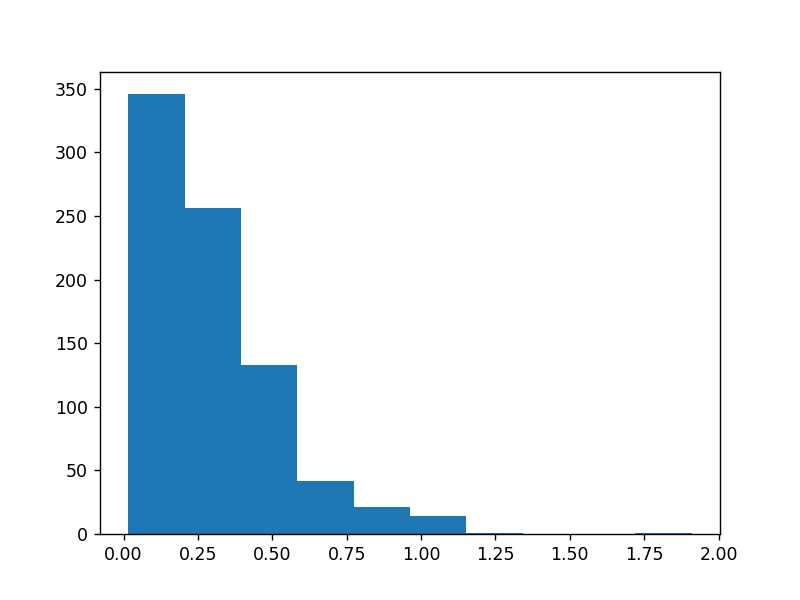

In [17]:
plt.figure(2)
plt.hist(std_dev_rr_stu)
plt.show()

In [18]:
thres_index_stu = np.where(std_dev_rr_stu>1.8)
for item in thres_index_stu[0]:
    error_inst_breaths[item] = 0
    error_avg_breaths[item] = 0
new_mae_avg_rr_student= np.mean(error_avg_breaths)
new_rmse_avg_rr_student = np.sqrt(np.mean(error_avg_breaths**2))

new_mae_inst_rr_student = np.mean(error_inst_breaths)
new_rmse_inst_rr_student = np.sqrt(np.mean(error_inst_breaths**2))

print('STUDENT--New Mean Absolute Error average wise for {} is: {}'.format(input_conf,new_mae_avg_rr_student))
print('STUDENT--New Root Mean Square Error average wise for {} is: {}'.format(input_conf,new_rmse_avg_rr_student))
    
print('STUDENT--New Mean Absolute Error instantaneous wise for {} is: {}'.format(input_conf,new_mae_inst_rr_student))
print('STUDENT--New Root Mean Square Error instantaneous wise for {} is: {}'.format(input_conf,new_rmse_inst_rr_student))

STUDENT--New Mean Absolute Error average wise for confd is: 2.370015574559347
STUDENT--New Root Mean Square Error average wise for confd is: 2.954842567624483
STUDENT--New Mean Absolute Error instantaneous wise for confd is: 3.33851697177112
STUDENT--New Root Mean Square Error instantaneous wise for confd is: 4.130654496862787


In [19]:
thres_index_stu

(array([61]), array([0]))

# STUDENT GROUND MODEL

In [20]:
if input_conf == 'confd':
    final_output = np.array([])
    final_output_rr = np.array([])
    final_attn1 = np.array([])
    final_attn2 = np.array([])
    #final_attn3 = np.array([])
    final_attn4 = np.array([])
    final_attn5 = np.array([])
    final_attn6 = np.array([])
    final_attn7 = np.array([])
    #final_attn8 = np.array([])
    #final_attn9 = np.array([])
    bottleneck_final = np.array([])
    model_input_shape = (128,3)
    model  = BRUnet_Multi_resp_student_2(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,128,3)))
    model.load_weights('/media/acrophase/pose1/charan/BR_Uncertainty/Knowledge_Distill/SAVED_MODEL_STU_GND_2/TEACHER_MODEL/best_model_10.01_0.0001_100alpha_0.94.h5')
    for i in tqdm.tqdm(range(10)):
        test_loss_list = []
        output_data = tf.convert_to_tensor([])
        output_data_rr = tf.convert_to_tensor([])
        attn1 = tf.convert_to_tensor([])
        attn2 = tf.convert_to_tensor([])
        #attn3 = tf.convert_to_tensor([])
        attn4 = tf.convert_to_tensor([])
        attn5 = tf.convert_to_tensor([])
        attn6 = tf.convert_to_tensor([])
        attn7 = tf.convert_to_tensor([])
        #attn8 = tf.convert_to_tensor([])
        #attn9 = tf.convert_to_tensor([])
        e6 = tf.convert_to_tensor([])
        for step , (x_batch_test,y_batch_test,x_batch_test_ref_rr) in enumerate(test_dataset):
            test_output,test_out_rr,e_6,at_1,at_2,at_4,at_5,at_6,at_7 = model(x_batch_test)
            test_loss_resp = loss_fn(y_batch_test  , test_output)
            test_loss_rr = loss_fn(x_batch_test_ref_rr , test_out_rr)
            test_loss = test_loss_resp + test_loss_rr
            if step == 0:
                output_data = test_output
                output_data_rr = test_out_rr
                attn1 = at_1
                attn2 = at_2
                #attn3 = at_3
                attn4 = at_4
                attn5 = at_5
                attn6 = at_6
                attn7 = at_7
                #attn8 = at_8
                #attn9 = at_9
                e6 = e_6
            else:
                output_data = tf.concat([output_data , test_output] , axis = 0)
                output_data_rr = tf.concat([output_data_rr , test_out_rr] , axis = 0)
                attn1 = tf.concat([attn1 , at_1] , axis = 0)
                attn2 = tf.concat([attn2 , at_2] , axis = 0)
                #attn3 = tf.concat([attn3 , at_3] , axis = 0)
                attn4 = tf.concat([attn4 , at_4] , axis = 0)
                attn5 = tf.concat([attn5 , at_5] , axis = 0)
                attn6 = tf.concat([attn6 , at_6] , axis = 0)
                attn7 = tf.concat([attn7 , at_7] , axis = 0)
                #attn8 = tf.concat([attn8 , at_8] , axis = 0)
                #attn9 = tf.concat([attn9 , at_9] , axis = 0)
                e6 = tf.concat([e6 , e_6] , axis = 0)
            test_loss_list.append(test_loss)
        output_array = output_data.numpy()
        output_array_rr = output_data_rr.numpy()
        attn1_array = attn1.numpy()
        attn2_array = attn2.numpy()
        #attn3_array = attn3.numpy()
        attn4_array = attn4.numpy()
        attn5_array = attn5.numpy()
        attn6_array = attn6.numpy()
        attn7_array = attn7.numpy()
        #attn8_array = attn8.numpy()
        #attn9_array = attn9.numpy()
        e6_array = e6.numpy()
        output_array = output_array.reshape(output_array.shape[-1],output_array.shape[0],output_array.shape[1])
        output_array_rr = output_array_rr.reshape(output_array_rr.shape[-1],output_array_rr.shape[0],output_array_rr.shape[1])
        attn1_array = np.expand_dims(attn1_array,axis = 0)
        attn2_array = np.expand_dims(attn2_array,axis = 0)
        #attn3_array = np.expand_dims(attn3_array,axis = 0)
        attn4_array = np.expand_dims(attn4_array,axis = 0)
        attn5_array = np.expand_dims(attn5_array,axis = 0)
        attn6_array = np.expand_dims(attn6_array,axis = 0)
        attn7_array = np.expand_dims(attn7_array,axis = 0)
        #attn8_array = np.expand_dims(attn8_array,axis = 0)
        #attn9_array = np.expand_dims(attn9_array,axis = 0)
        e6_array = np.expand_dims(e6_array,axis = 0)
        if i == 0:
            final_output = output_array
            final_output_rr = output_array_rr
            final_attn1 = attn1_array
            final_attn2 = attn2_array
            #final_attn3 = attn3_array
            final_attn4 = attn4_array
            final_attn5 = attn5_array
            final_attn6 = attn6_array
            final_attn7 = attn7_array
            #final_attn8 = attn8_array
            #final_attn9 = attn9_array
            bottleneck_final = e6_array
        else:
            final_output = np.vstack((final_output,output_array))
            final_output_rr = np.vstack((final_output_rr,output_array_rr))
            final_attn1 = np.vstack((final_attn1,attn1_array))
            final_attn2 = np.vstack((final_attn2,attn2_array))
            #final_attn3 = np.vstack((final_attn3,attn3_array))
            final_attn4 = np.vstack((final_attn4,attn4_array))
            final_attn5 = np.vstack((final_attn5,attn5_array))
            final_attn6 = np.vstack((final_attn6,attn6_array))
            final_attn7 = np.vstack((final_attn7,attn7_array))
            #final_attn8 = np.vstack((final_attn8,attn8_array))
            #final_attn9 = np.vstack((final_attn9,attn9_array))
            bottleneck_final = np.vstack((bottleneck_final,e6_array))
    model.summary()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.05it/s]

Model: "br_unet__multi_resp_student_2_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_171 (Sequential)  (None, 32, 32)            15136     
_________________________________________________________________
sequential_176 (Sequential)  (None, 16, 64)            64640     
_________________________________________________________________
sequential_181 (Sequential)  (None, 8, 128)            224000    
_________________________________________________________________
sequential_186 (Sequential)  (None, 8, 1024)           9909248   
_________________________________________________________________
attention_block_15 (Attentio multiple                  1054725   
_________________________________________________________________
sequential_193 (Sequential)  (None, 2, 32)             551360    
_________________________________________________________________
attention_block_16 (Attentio multip

In [21]:
if input_conf == 'confd':
    #l = 0.1
    #drop_prob = 0.1
    #lam = 0.0001
    
    #l_rr = 0.01
    #drop_prob_rr = 0.1
    #lam_rr = 0.0001
    
    final_output_resp_sig = []
    inst_br_dur = []
    inst_ref_br_dur = []
    inst_rr = []
    inst_ref_rr = []
    
    final_attn1_output = np.mean(final_attn1 , axis = 0)
    final_attn2_output = np.mean(final_attn2 , axis = 0)
    #final_attn3_output = np.mean(final_attn3 , axis = 0)
    final_attn4_output = np.mean(final_attn4 , axis = 0)
    final_attn5_output = np.mean(final_attn5 , axis = 0)
    final_attn6_output = np.mean(final_attn6 , axis = 0)
    final_attn7_output = np.mean(final_attn7 , axis = 0)
    #final_attn8_output = np.mean(final_attn8 , axis = 0)
    #final_attn9_output = np.mean(final_attn9 , axis = 0)
    #bottleneck_output = np.mean(bottleneck_final , axis = 0)
    
    final_output_resp = np.mean(final_output,axis = 0)
    final_rr = np.mean(final_output_rr,axis = 0)
    #tau = (l**2) * (1-drop_prob) / (2. * lam)
    #tau_rr = (l_rr**2) * (1-drop_prob_rr) / (2. * lam_rr)
    
    final_var = np.var(final_output,axis = 0)
    final_var_rr = np.var(final_output_rr,axis = 0)
    #final_var += (tau**-1)
    #final_var_rr += (tau_rr**-1)
    output_copy = final_output_resp
    output_copy_rr = final_rr
    std_dev = np.sqrt(final_var)
    std_dev_rr_stu_gnd = np.sqrt(final_var_rr)
    for item in final_output_resp:
        final_output_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
        
    final_output_resp_sig = np.array(final_output_resp_sig)
    duration_resp,extremas_resp = extremas_extraction(final_output_resp_sig)
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    
    error_avg_breaths = np.abs(avg_ref_breath - final_rr)
    mae_avg_breath = np.mean(error_avg_breaths)
    rmse_avg_breath = np.sqrt(np.mean(error_avg_breaths**2))
    
    for item in extremas_resp:
        inst_br_dur.append(np.diff(item[0::2]))
    for item in extremas_ref_resp:
        inst_ref_br_dur.append(np.diff(item[0::2]))
    for item in inst_br_dur:
        inst_rr.append(np.mean(60*4/item))
    for item in inst_ref_br_dur:
        inst_ref_rr.append(np.mean(60*4/item))
    
    inst_rr = (np.array(inst_rr)).reshape(-1,1)
    inst_ref_rr = (np.array(inst_ref_rr)).reshape(-1,1)
    
    error_inst_breaths = np.abs(inst_ref_rr - inst_rr)
    mae_inst_breath = np.mean(error_inst_breaths)
    rmse_inst_breath = np.sqrt(np.mean(error_inst_breaths**2))
    
    samples = np.arange(0,len(final_rr)).reshape(-1,1)
    confd_data = np.hstack((samples,final_rr , std_dev_rr_stu_gnd,error_avg_breaths, error_inst_breaths))
    col_confd = ['Samples','Final RR Output (BrPM)' , 'Uncertainty', 'Error Avg Breath(BrPM)','Error Inst Breath(BrPM)']
    data_confd = pd.DataFrame(confd_data , columns = col_confd)
    
    print('Mean Absolute Error average wise for {} is: {}'.format(input_conf,mae_avg_breath))
    print('Root Mean Square Error average wise for {} is: {}'.format(input_conf,rmse_avg_breath))
    
    print('Mean Absolute Error instantaneous wise for {} is: {}'.format(input_conf,mae_inst_breath))
    print('Root Mean Square Error instantaneous wise for {} is: {}'.format(input_conf,rmse_inst_breath))
    

Mean Absolute Error average wise for confd is: 2.357605173279192
Root Mean Square Error average wise for confd is: 2.9577178950947642
Mean Absolute Error instantaneous wise for confd is: 2.9537404332937887
Root Mean Square Error instantaneous wise for confd is: 3.7537094773270114


In [22]:
if input_conf == 'confc' or input_conf == 'confe' or input_conf == 'confd' or input_conf == 'conff':
    no_of_samples = 32*4
    x_unc = np.linspace(start = 0,stop = no_of_samples, num = no_of_samples)
    layout_epistemic = go.Layout(
    title = "Respiratory Waveform with Epistemic Uncertainty for "+ input_conf.upper(),
    yaxis = dict(
        title = 'Output Respiration Signal' 
    ),
    xaxis = dict(
        title = 'samples'
    )
    )
    def update_plot(signals):
        data = []
            # Reference ECG trace
        trace_epistemic = go.Scatter(
            x = x_unc,
            y = final_output_resp_sig[signals], 
            mode = 'lines',
            name = 'Respiration with Epistemic',
                    line = dict(
                    shape = 'spline',
                    color = 'red',
                    width = 5
                     ),
                error_y=dict(
                    type='data', # value of error bar given in data coordinates
                    array=final_var[signals],
                    visible=True,
                    color='black',
                thickness=3,
                width=5)
                )
        fig_epistemic = go.Figure(data = [trace_epistemic],layout = layout_epistemic)
        py.offline.iplot(fig_epistemic)
signals_epsitemic = widgets.IntSlider(min = 0,max = len(final_output_resp_sig), value = 0, description = 'Record_no:')
widgets.interactive(update_plot, signals = signals_epsitemic)

interactive(children=(IntSlider(value=0, description='Record_no:', max=814), Output()), _dom_classes=('widget-…

In [23]:
if input_conf == 'confd':
    fig1 = px.scatter(data_confd,x = 'Samples', y="Error Avg Breath(BrPM)",title="Uncertainty Distribution for "+input_conf.upper()+ " for average RR error" ,
                     color="Uncertainty", color_continuous_scale=px.colors.sequential.Viridis)
    fig1.update_traces(marker=dict(size=10 ),selector=dict(mode='markers'))
    
    fig2 = px.scatter(data_confd,x = 'Samples', y="Error Inst Breath(BrPM)",title="Uncertainty Distribution for "+input_conf.upper()+ " for instantaneous RR error" ,
                     color="Uncertainty", color_continuous_scale=px.colors.sequential.Viridis)
    fig2.update_traces(marker=dict(size=10),selector=dict(mode='markers'))
    fig1.show()
    fig2.show()

<IPython.core.display.Javascript object>


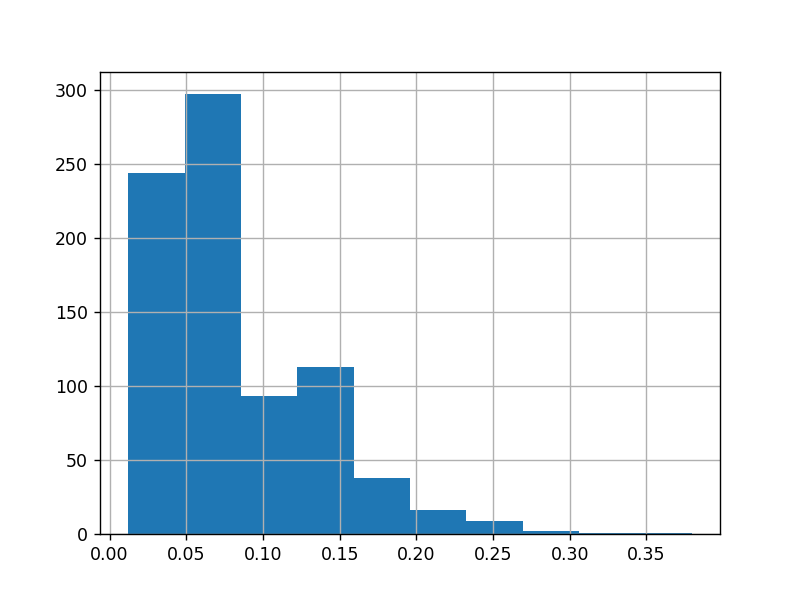

In [24]:
plt.figure(3)
plt.hist(std_dev_rr_stu_gnd)
plt.grid(True)
plt.show()

In [29]:
thres_index_stu = np.where(std_dev_rr_stu_gnd>0.25)
for item in thres_index_stu[0]:
    error_inst_breaths[item] = 0
    error_avg_breaths[item] = 0
new_mae_avg_rr_student= np.mean(error_avg_breaths)
new_rmse_avg_rr_student = np.sqrt(np.mean(error_avg_breaths**2))

new_mae_inst_rr_student = np.mean(error_inst_breaths)
new_rmse_inst_rr_student = np.sqrt(np.mean(error_inst_breaths**2))

print('STUDENT--New Mean Absolute Error average wise for {} is: {}'.format(input_conf,new_mae_avg_rr_student))
print('STUDENT--New Root Mean Square Error average wise for {} is: {}'.format(input_conf,new_rmse_avg_rr_student))
    
print('STUDENT--New Mean Absolute Error instantaneous wise for {} is: {}'.format(input_conf,new_mae_inst_rr_student))
print('STUDENT--New Root Mean Square Error instantaneous wise for {} is: {}'.format(input_conf,new_rmse_inst_rr_student))

STUDENT--New Mean Absolute Error average wise for confd is: 2.2694585023873928
STUDENT--New Root Mean Square Error average wise for confd is: 2.900710352427236
STUDENT--New Mean Absolute Error instantaneous wise for confd is: 2.8664932773372374
STUDENT--New Root Mean Square Error instantaneous wise for confd is: 3.702698314952215


In [30]:
len(thres_index_stu[0])

8